In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

#**Base de datos**
El conjunto de datos se generó mediante un programa de Monte Carlo, Corsika, descrito en:
    D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers,
    Forschungszentrum Karlsruhe FZKA 6019 (1998).
http://rexa.info/paper?id=ac6e674e9af20979b23d3ed4521f1570765e8d68

In [7]:
cols = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df = pd.read_csv('magic04.data', names = cols)
df.head(3)

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g

In [8]:
df['class'] = (df['class'] == 'g').astype(int)

Cambiamos los valores de g por 1 y h por 0 para poder utilizar modelos de ML que necesita valores numéricos.

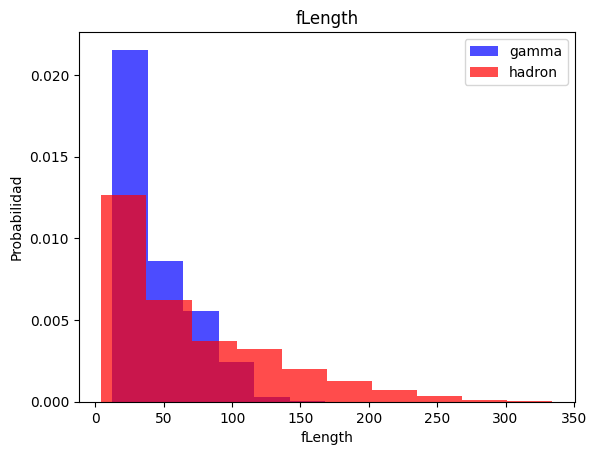

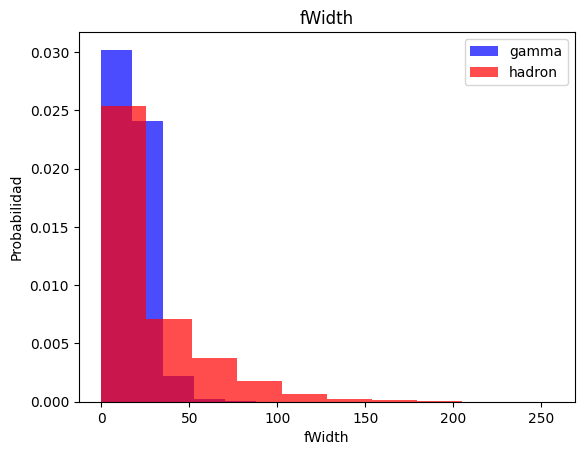

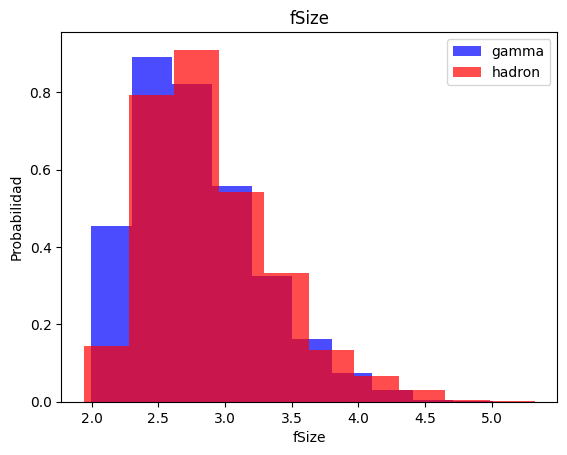

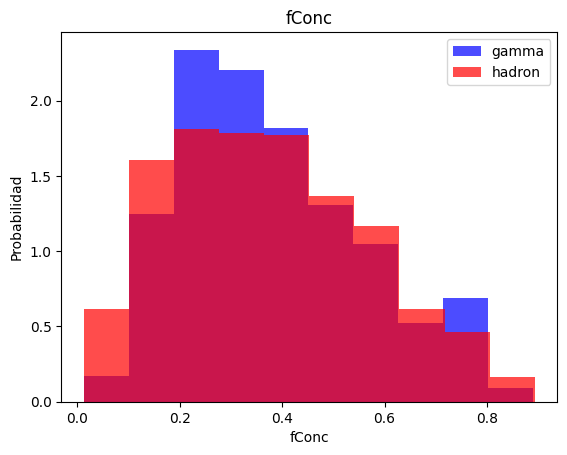

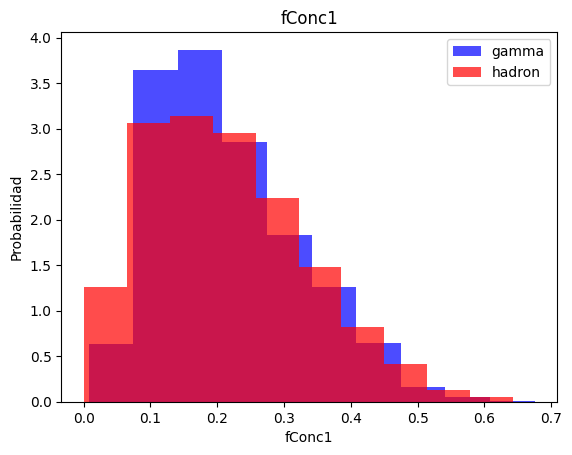

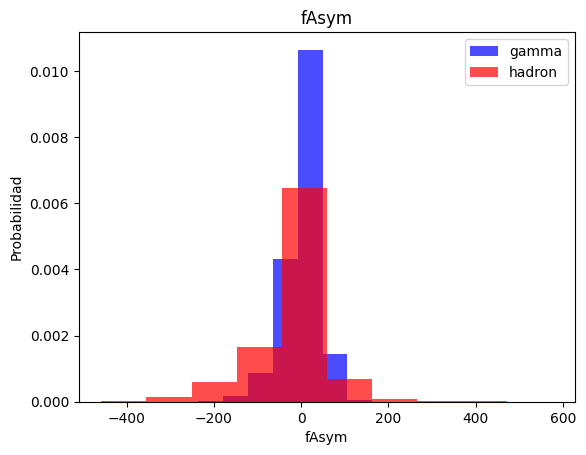

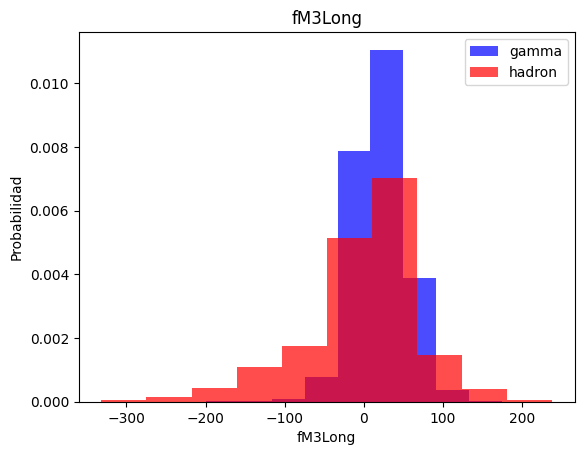

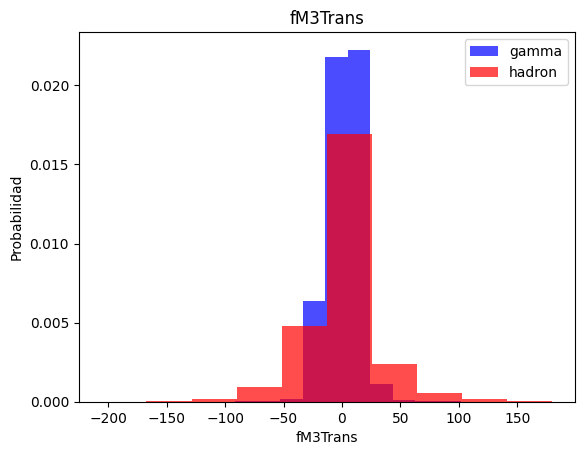

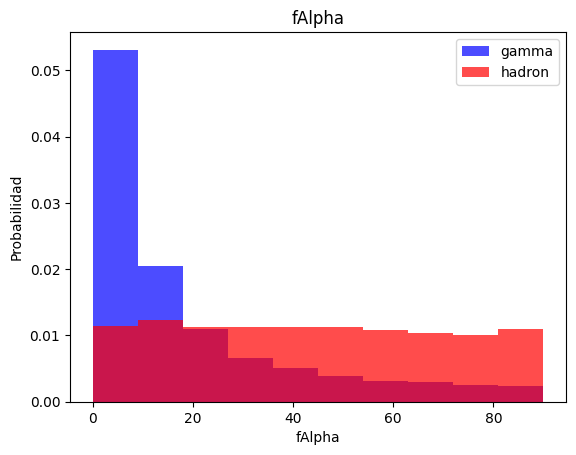

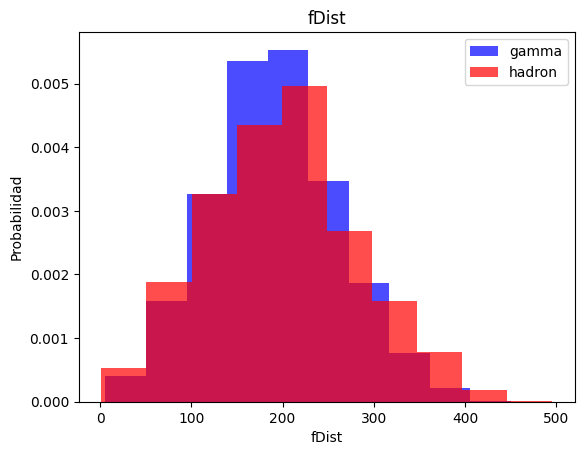

In [18]:
for label in cols[:-1]:
  plt.hist(df[df['class'] == 1][label], color = 'blue', label = 'gamma', alpha = 0.7, density =True)
  plt.hist(df[df['class'] == 0][label], color = 'red', label = 'hadron', alpha = 0.7, density =True)
  plt.title(label)
  plt.ylabel('Probabilidad')
  plt.xlabel(label)
  plt.legend()
  plt.show()

Podemos observar que gracias al histograma existen diferentes comportamientos en las columnas:

fLength donde gamma tiene un comportamiento más alto.
fAsym gamma tiene un comportamiento más alto.
fAlpha gamma tiene una distribución exponencial, mientras que hadron tiene una distribución mas uniforme.

Mientras las demás tiene comportamientos más similares entre sí.

# Entrenamiento, validacion, prueba set de datos

Para crear un set de entrenamiento, validación y prueba utilizamos la función split con los valores de 60%, 20% y 20% respectivamente.

In [34]:
train, valid , test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


El set de datos tiene valores que tiene mucha diferencia el uno con el otro, es por esto que se crea una función que escala los datos, la función utiliza la estandarización, es decir, restar su promedio y dividir por su desviación estándar.

Otro punto es que queremos juntar los datos para crear data y tienen dimensiones distintas por lo que se utiliza reshape para cambiar la dimensión de **y** (1, escalar) a (2, una matriz).

In [35]:
def scale_dataset(dataframe, oversample = False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X,y)

  data = np.hstack((X, np.reshape(y, (-1,1))))

  return data, X, y

In [22]:
print(len(train[train['class']==1])) # Gamma
print(len(train[train['class']==0])) # Hadron

7450
3962


Encontramos que existe una diferencias entre los valores de Gamma y Hadron que pueden generar problemas al querer utilizar modelos de predicción, puesto que se puede sobreponer los valores. Es por esto que es necesario generar una nueva muestra más proporcional entre sí.

In [36]:
train, X_train, y_train = scale_dataset(train, oversample=True)

In [30]:
print(len(y_train))
print(sum(y_train == 1))
print(sum(y_train == 0))

14900
7450
7450


In [37]:
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

Para los datos de validación y prueba utilizamos los valores originales para que la predicción no se distorsioné de la realidad del set de datos.

# KNN

Método de k vecino más cercano

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [76]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [77]:
y_pred = knn_model.predict(X_test)

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1330
           1       0.83      0.89      0.86      2474

    accuracy                           0.81      3804
   macro avg       0.80      0.78      0.79      3804
weighted avg       0.81      0.81      0.81      3804



In [85]:
knn_model3 = KNeighborsClassifier(n_neighbors=3)
knn_model3.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [86]:
y_pred3 = knn_model3.predict(X_test)

In [87]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1330
           1       0.85      0.86      0.86      2474

    accuracy                           0.81      3804
   macro avg       0.79      0.79      0.79      3804
weighted avg       0.81      0.81      0.81      3804



In [88]:
knn_model20 = KNeighborsClassifier(n_neighbors=20)
knn_model20.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [89]:
y_pred20 = knn_model20.predict(X_test)

In [90]:
print(classification_report(y_test, y_pred20))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1330
           1       0.86      0.88      0.87      2474

    accuracy                           0.83      3804
   macro avg       0.81      0.80      0.81      3804
weighted avg       0.82      0.83      0.82      3804



En este caso observamos que a medida que tenemos más n vecinos tenemos mejores resultados.

# Bayesiano ingenuo

In [92]:
from sklearn.naive_bayes import GaussianNB

In [93]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

In [96]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50      1330
           1       0.73      0.90      0.81      2474

    accuracy                           0.72      3804
   macro avg       0.70      0.65      0.65      3804
weighted avg       0.71      0.72      0.70      3804



El modelo no parece ajustarse de la mejor manera para entregarnos los mejores resultados.

# Regresión logística

In [97]:
from sklearn.linear_model import LogisticRegression

In [98]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

In [99]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1330
           1       0.84      0.81      0.82      2474

    accuracy                           0.77      3804
   macro avg       0.75      0.76      0.76      3804
weighted avg       0.78      0.77      0.78      3804



El modelo nos entrega mejor resultados mejores que Bayes, pero no KNN.

# Máquina de vectores de soporte

In [100]:
from sklearn.svm import SVC

In [101]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [102]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1330
           1       0.88      0.90      0.89      2474

    accuracy                           0.86      3804
   macro avg       0.84      0.84      0.84      3804
weighted avg       0.86      0.86      0.86      3804



Con este modelo tenemos el mejor resultado con todos los métodos anteriores.

# Redes neuronales

In [104]:
import tensorflow as tf

In [116]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [115]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

16 nodes, dropout 0, lr 0.01, batch size 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


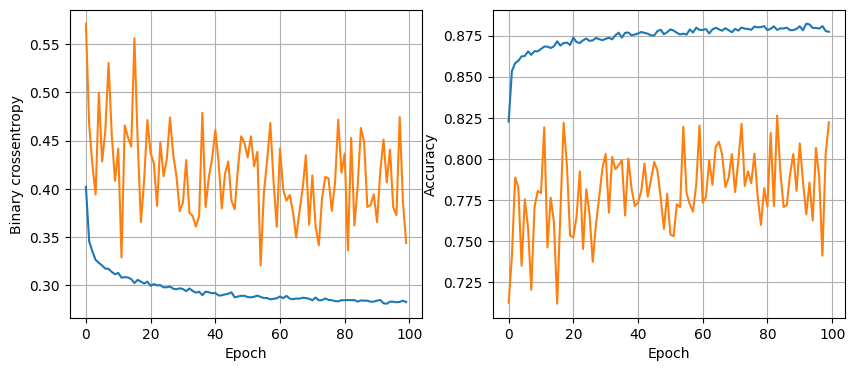

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8652 - loss: 0.3231
16 nodes, dropout 0, lr 0.01, batch size 64


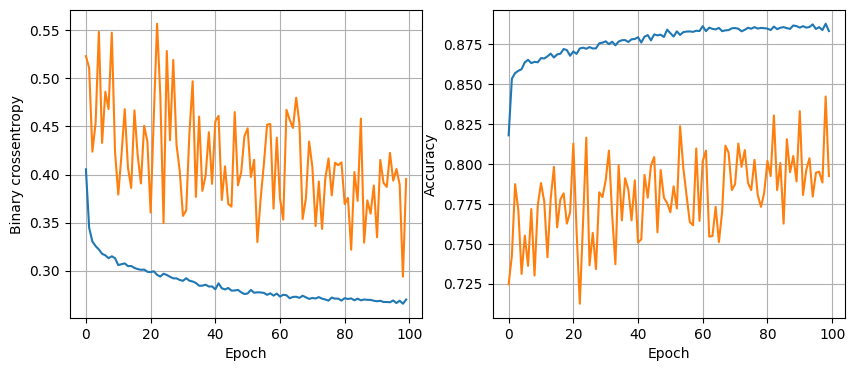

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8707 - loss: 0.3205
16 nodes, dropout 0, lr 0.01, batch size 128


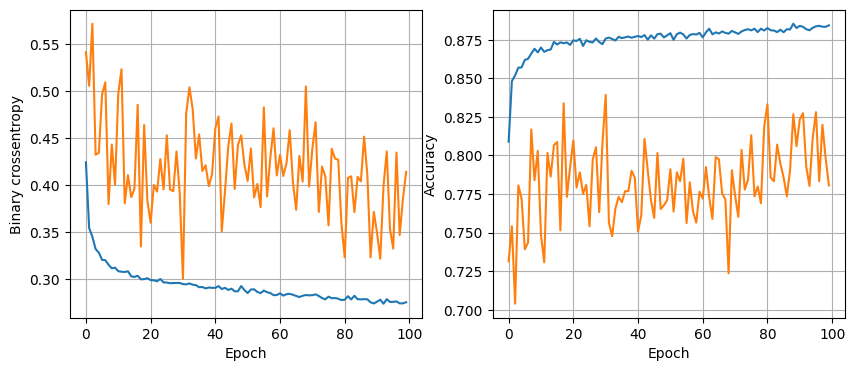

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8671 - loss: 0.3188
16 nodes, dropout 0, lr 0.005, batch size 32


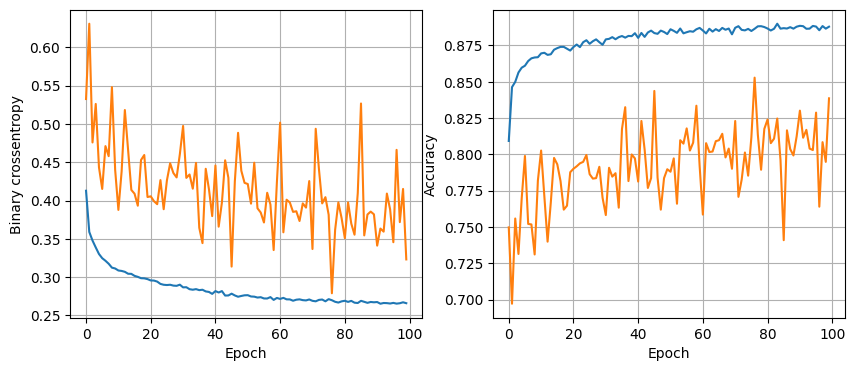

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.3080
16 nodes, dropout 0, lr 0.005, batch size 64


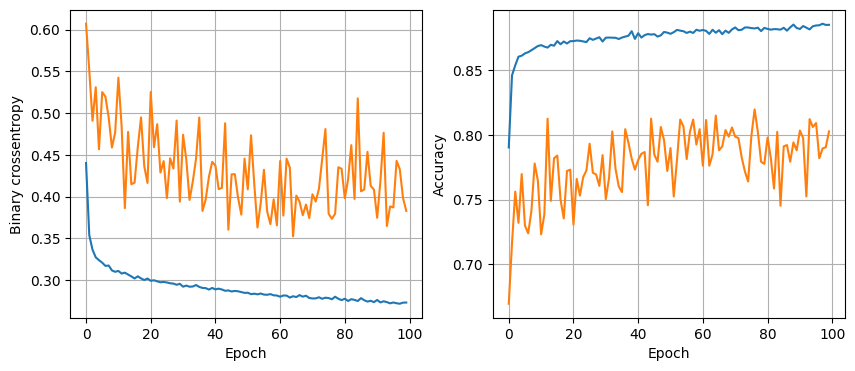

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8676 - loss: 0.3163
16 nodes, dropout 0, lr 0.005, batch size 128


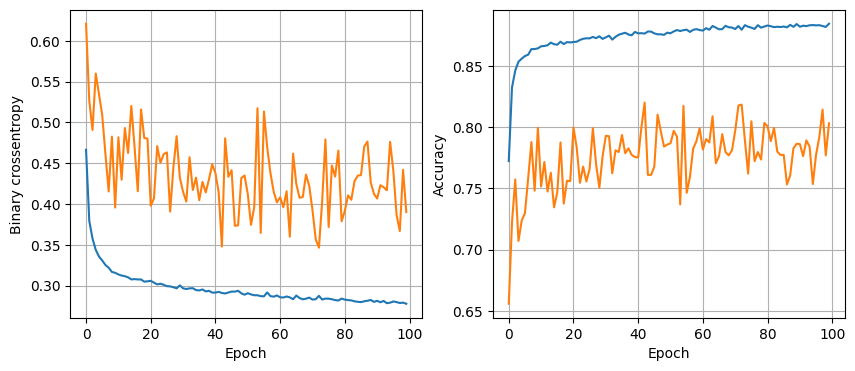

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.3227
16 nodes, dropout 0, lr 0.001, batch size 32


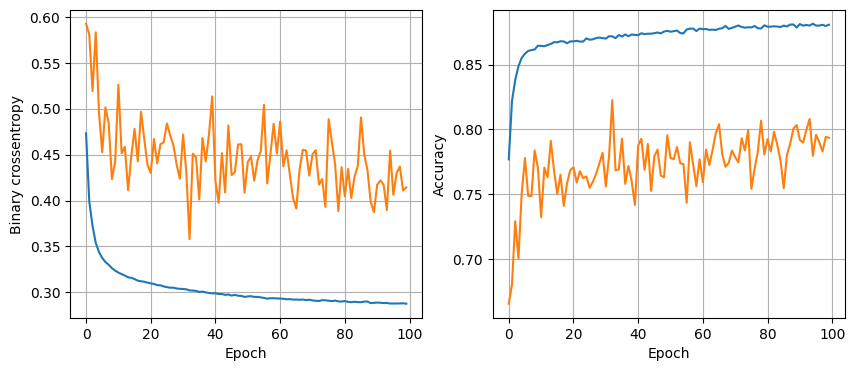

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8683 - loss: 0.3099
16 nodes, dropout 0, lr 0.001, batch size 64


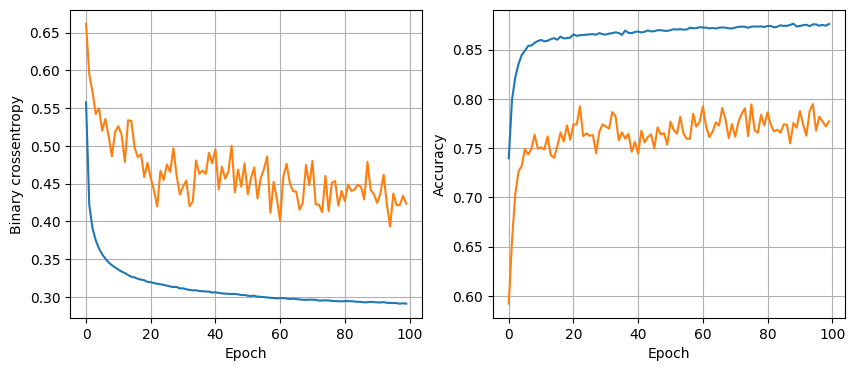

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8694 - loss: 0.3066
16 nodes, dropout 0, lr 0.001, batch size 128


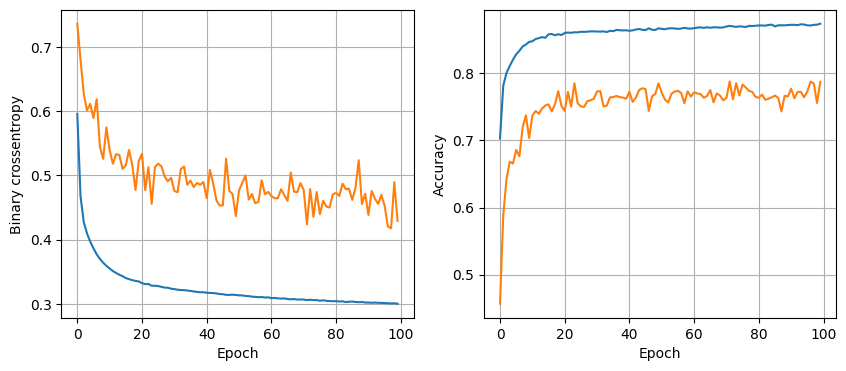

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8723 - loss: 0.3233
16 nodes, dropout 0.2, lr 0.01, batch size 32


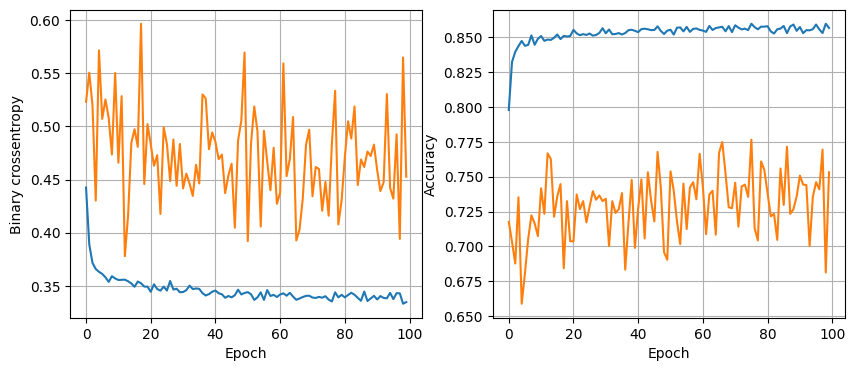

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8744 - loss: 0.3094
16 nodes, dropout 0.2, lr 0.01, batch size 64


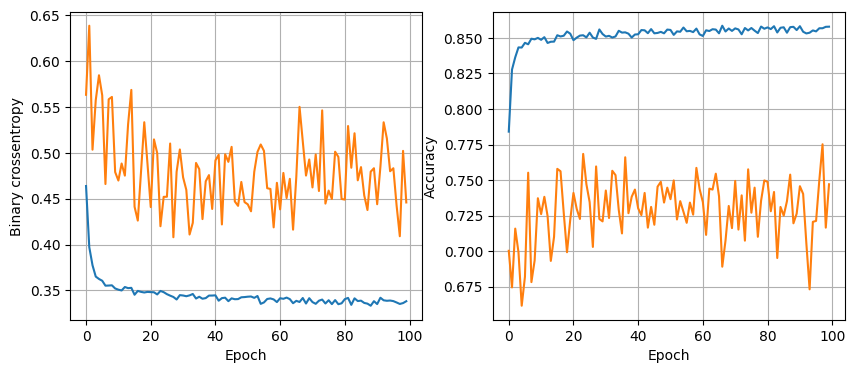

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8780 - loss: 0.3087
16 nodes, dropout 0.2, lr 0.01, batch size 128


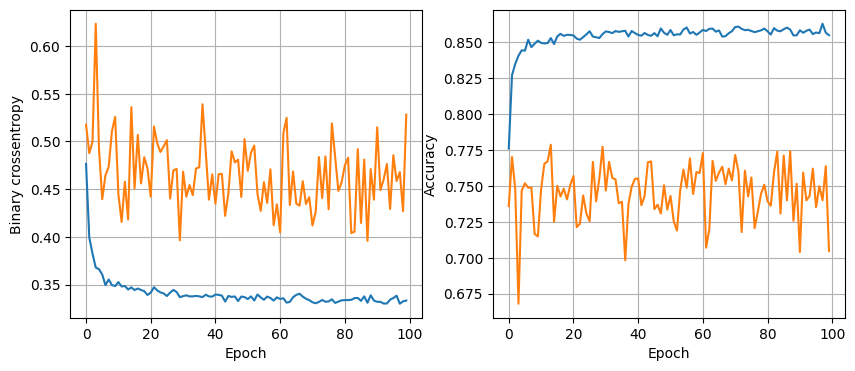

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8600 - loss: 0.3257
16 nodes, dropout 0.2, lr 0.005, batch size 32


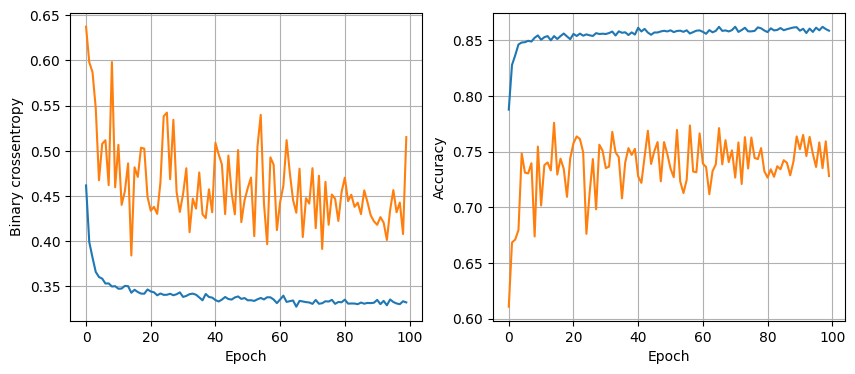

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8676 - loss: 0.3135
16 nodes, dropout 0.2, lr 0.005, batch size 64


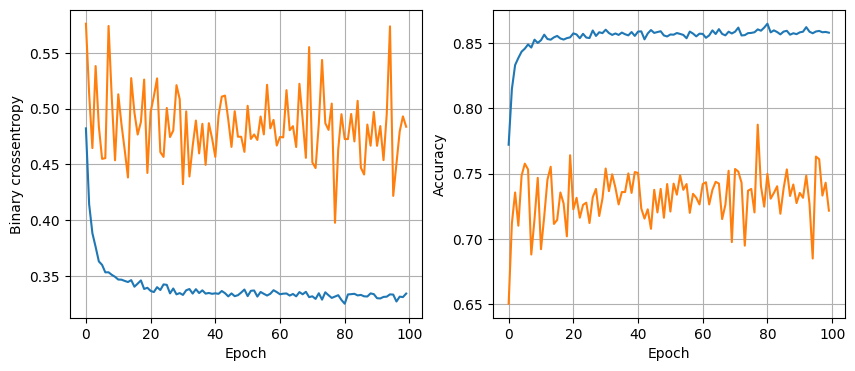

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8667 - loss: 0.3108
16 nodes, dropout 0.2, lr 0.005, batch size 128


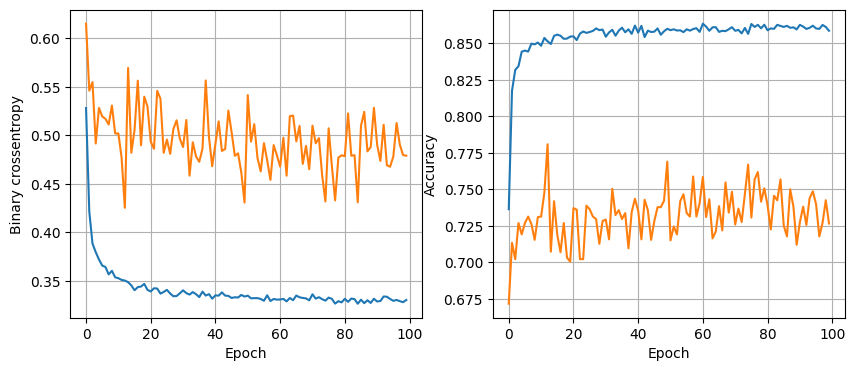

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8710 - loss: 0.3150
16 nodes, dropout 0.2, lr 0.001, batch size 32


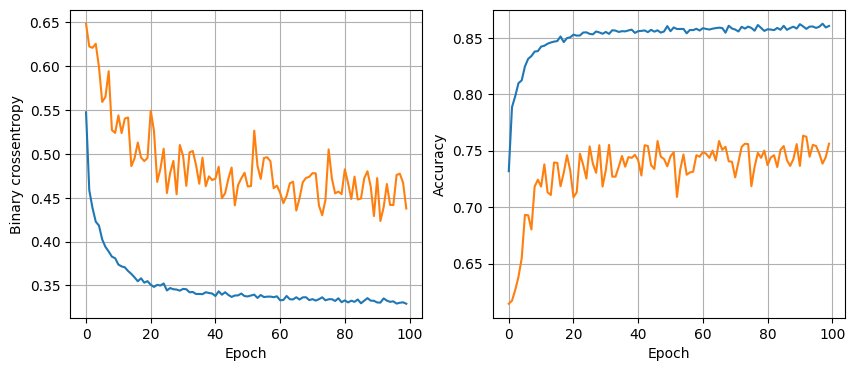

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8727 - loss: 0.3177
16 nodes, dropout 0.2, lr 0.001, batch size 64


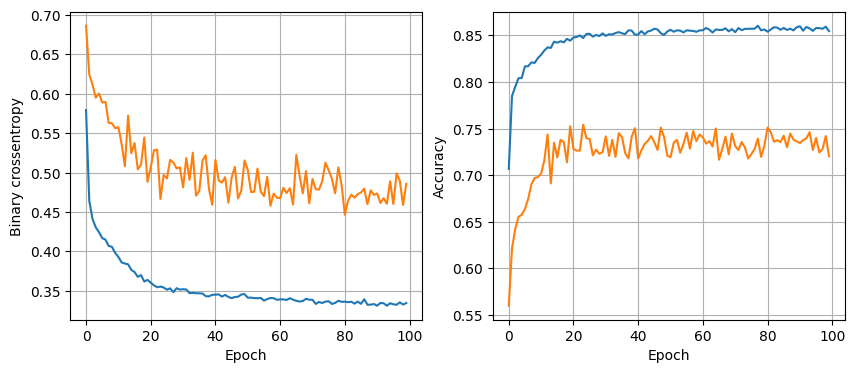

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.3146
16 nodes, dropout 0.2, lr 0.001, batch size 128


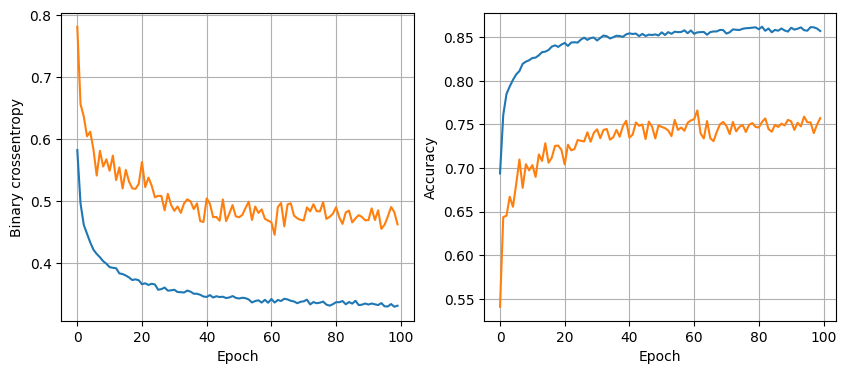

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.3137
32 nodes, dropout 0, lr 0.01, batch size 32


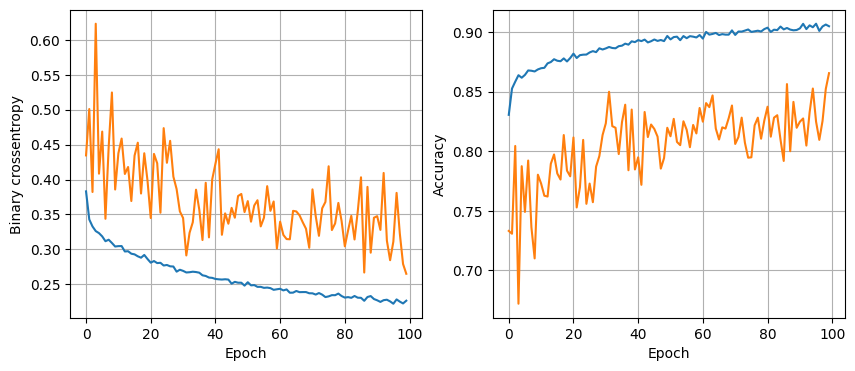

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8595 - loss: 0.4073
32 nodes, dropout 0, lr 0.01, batch size 64


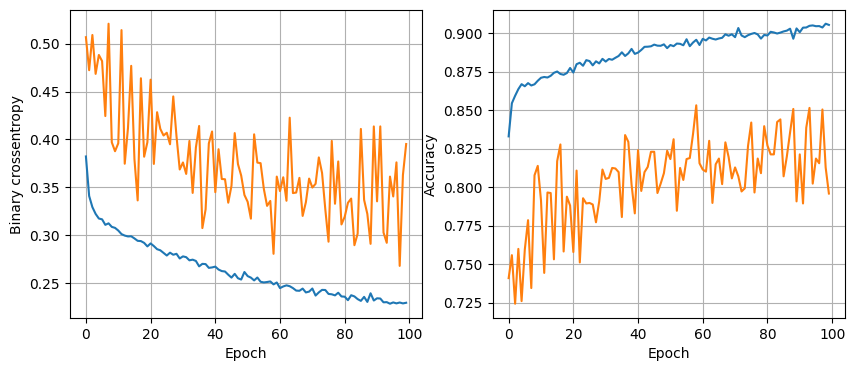

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8585 - loss: 0.4045
32 nodes, dropout 0, lr 0.01, batch size 128


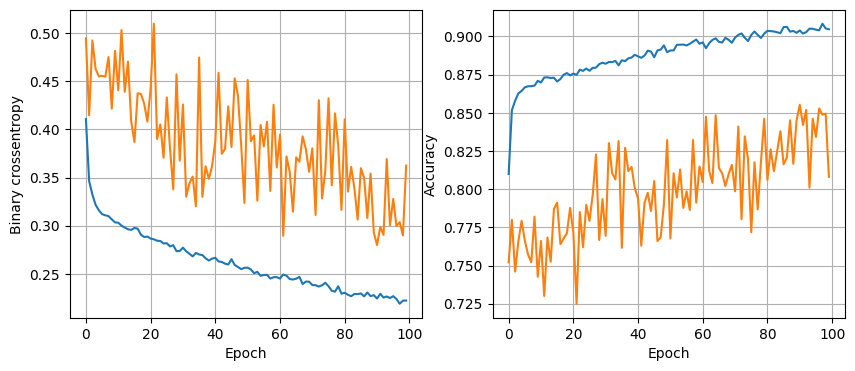

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8607 - loss: 0.3644
32 nodes, dropout 0, lr 0.005, batch size 32


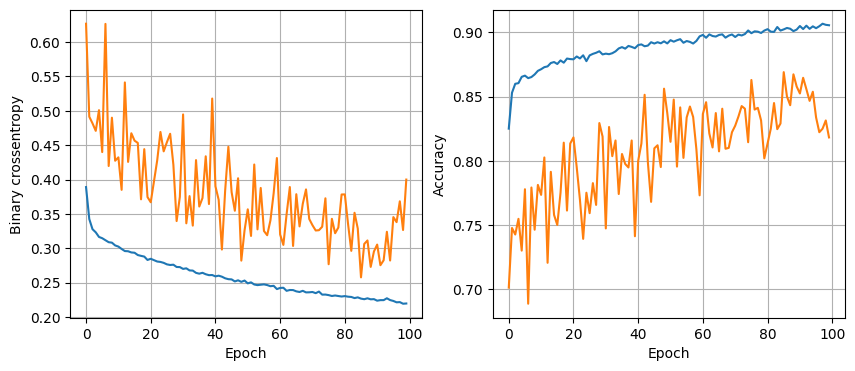

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8615 - loss: 0.3986
32 nodes, dropout 0, lr 0.005, batch size 64


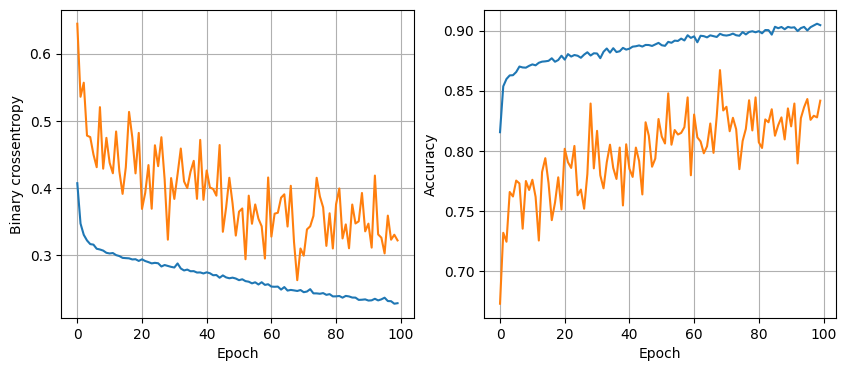

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss: 0.3721
32 nodes, dropout 0, lr 0.005, batch size 128


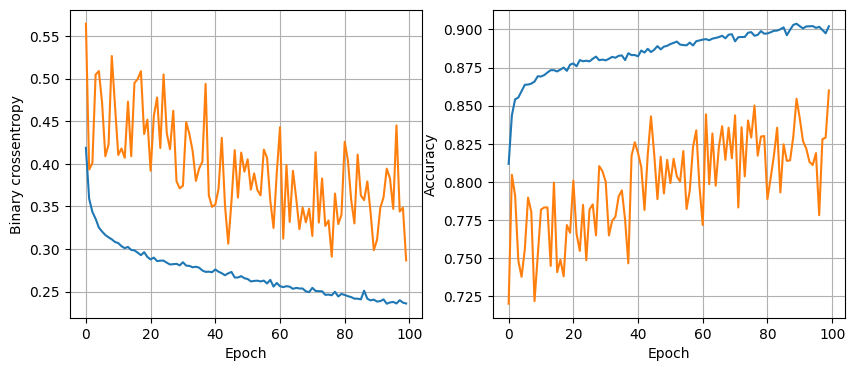

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8603 - loss: 0.3467
32 nodes, dropout 0, lr 0.001, batch size 32


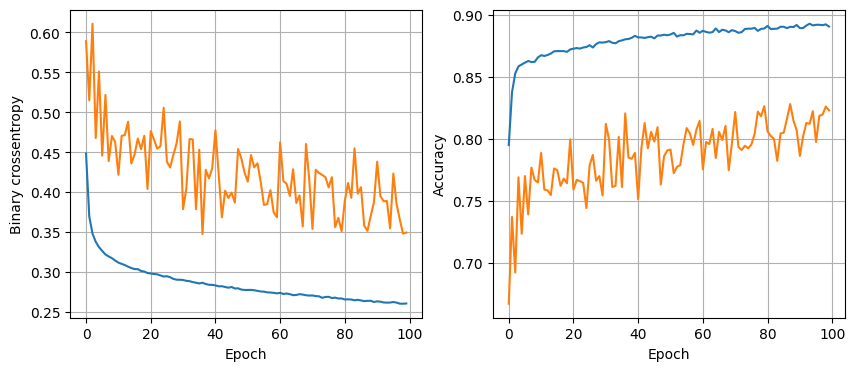

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8675 - loss: 0.3276
32 nodes, dropout 0, lr 0.001, batch size 64


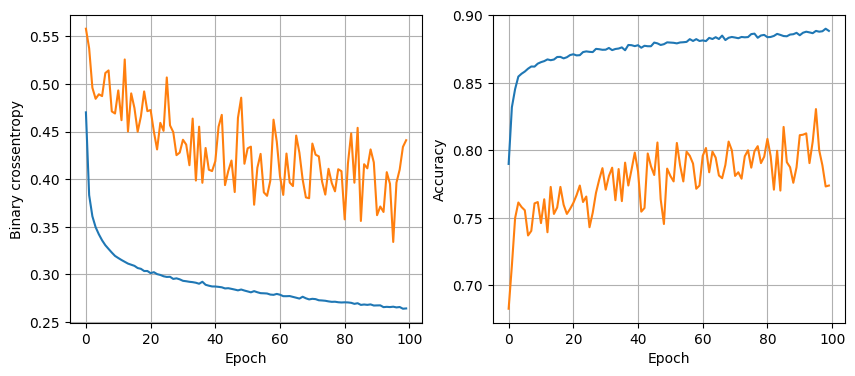

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8677 - loss: 0.3185
32 nodes, dropout 0, lr 0.001, batch size 128


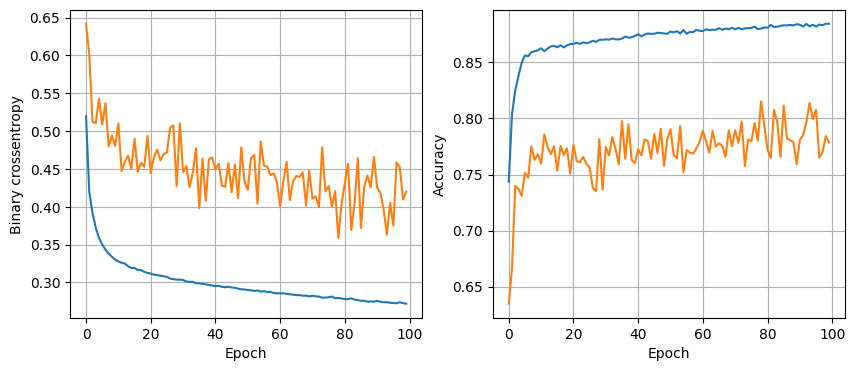

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8682 - loss: 0.3140
32 nodes, dropout 0.2, lr 0.01, batch size 32


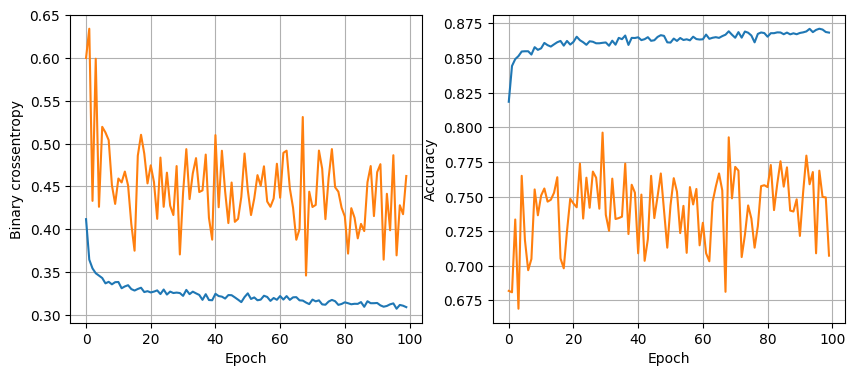

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8657 - loss: 0.3175
32 nodes, dropout 0.2, lr 0.01, batch size 64


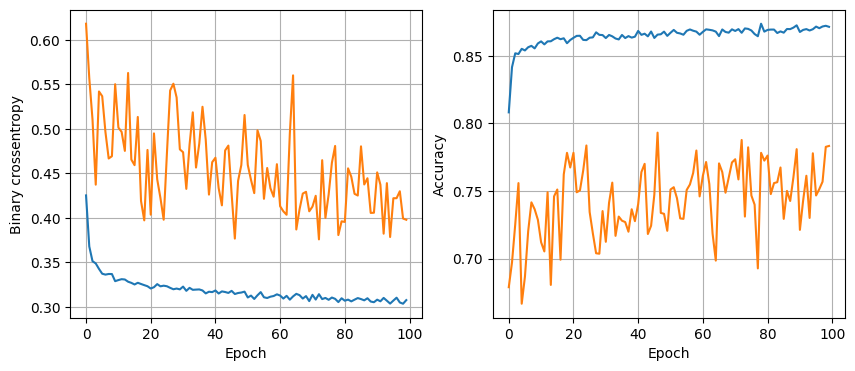

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8769 - loss: 0.3102
32 nodes, dropout 0.2, lr 0.01, batch size 128


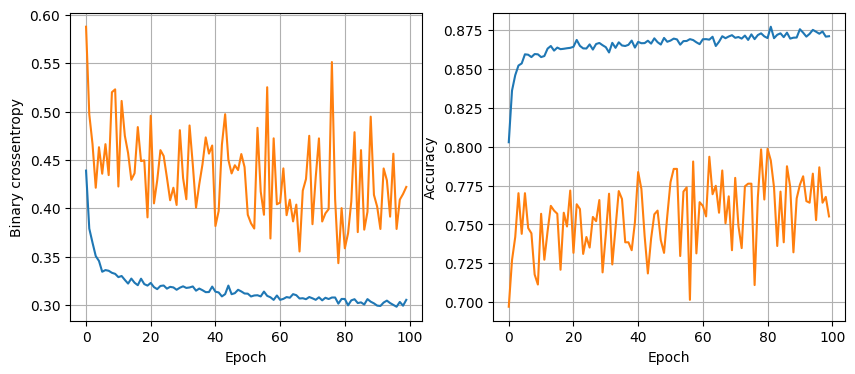

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8764 - loss: 0.3067
32 nodes, dropout 0.2, lr 0.005, batch size 32


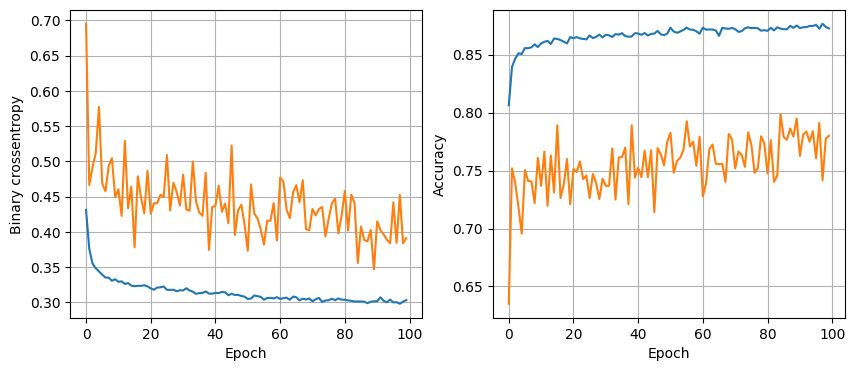

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8789 - loss: 0.3020
32 nodes, dropout 0.2, lr 0.005, batch size 64


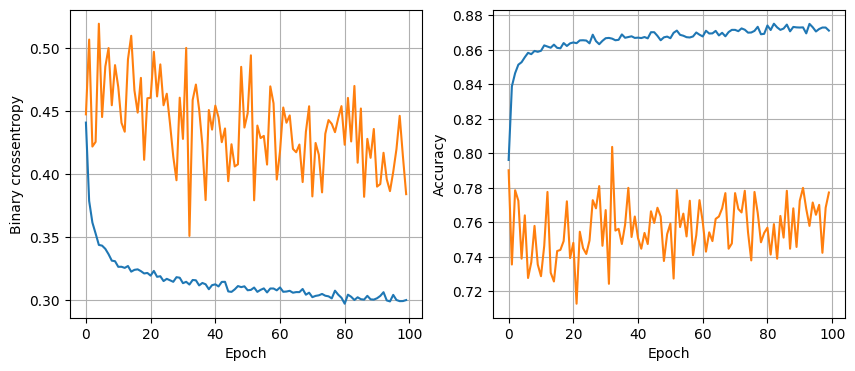

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8782 - loss: 0.3059
32 nodes, dropout 0.2, lr 0.005, batch size 128


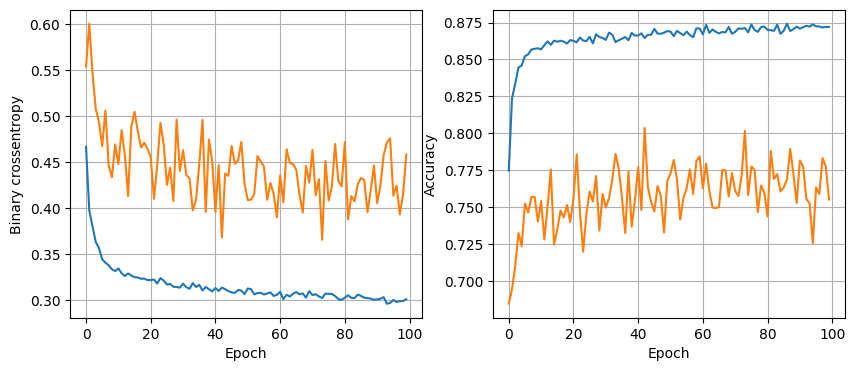

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.3022
32 nodes, dropout 0.2, lr 0.001, batch size 32


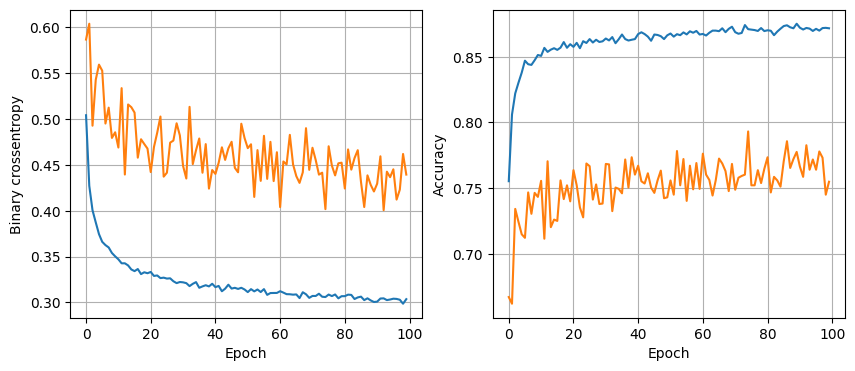

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8692 - loss: 0.3009
32 nodes, dropout 0.2, lr 0.001, batch size 64


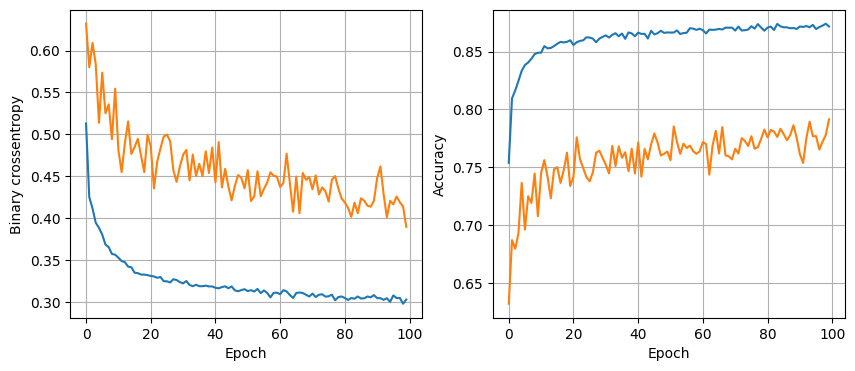

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.3038
32 nodes, dropout 0.2, lr 0.001, batch size 128


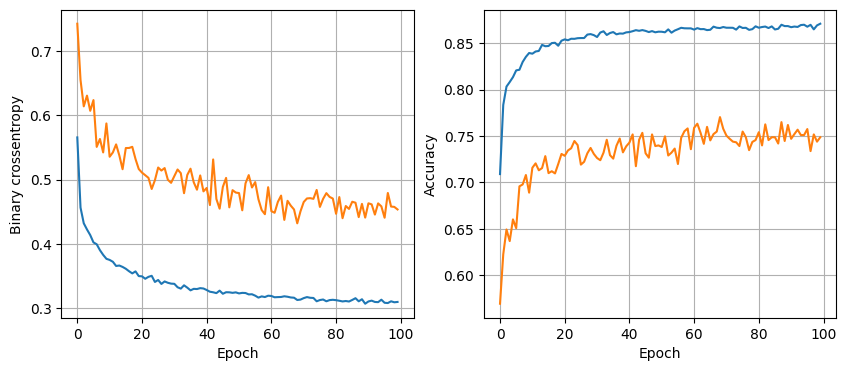

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8694 - loss: 0.3060
64 nodes, dropout 0, lr 0.01, batch size 32


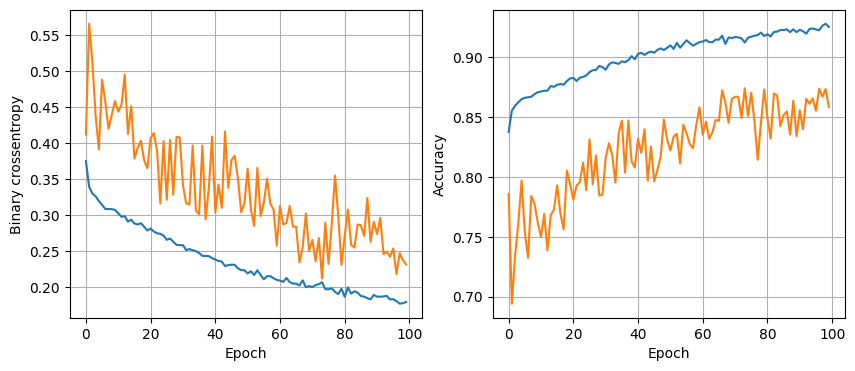

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8614 - loss: 0.5492
64 nodes, dropout 0, lr 0.01, batch size 64


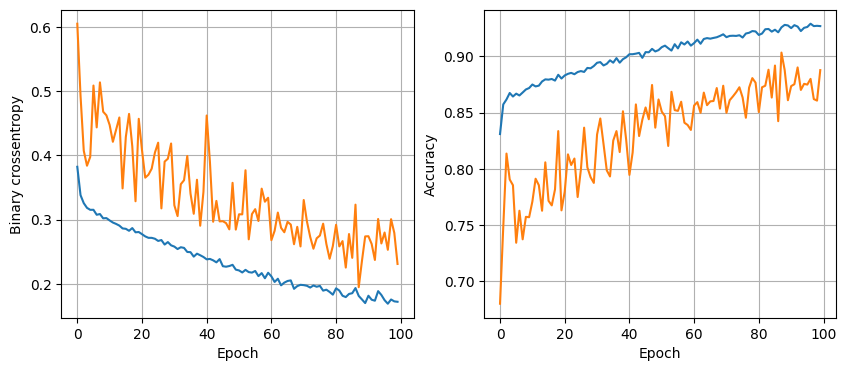

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.5447
64 nodes, dropout 0, lr 0.01, batch size 128


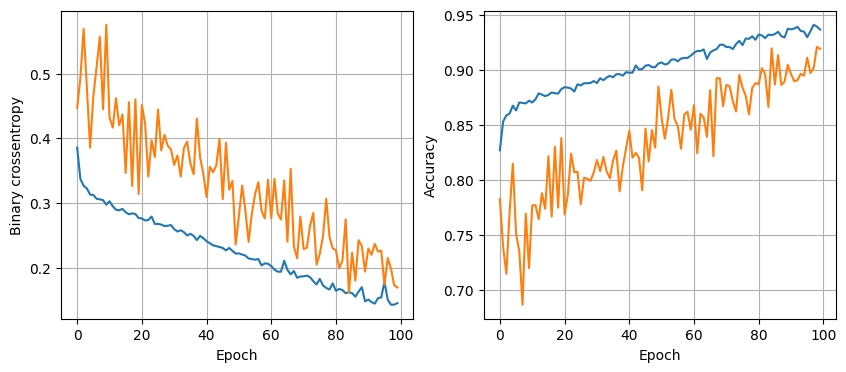

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8390 - loss: 0.6171
64 nodes, dropout 0, lr 0.005, batch size 32


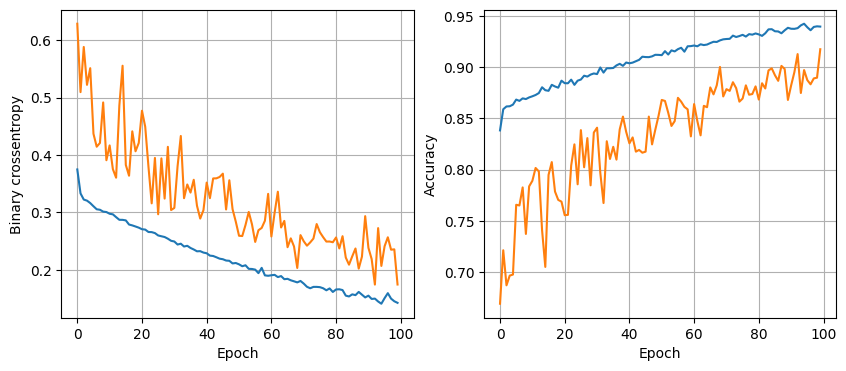

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8422 - loss: 0.6286
64 nodes, dropout 0, lr 0.005, batch size 64


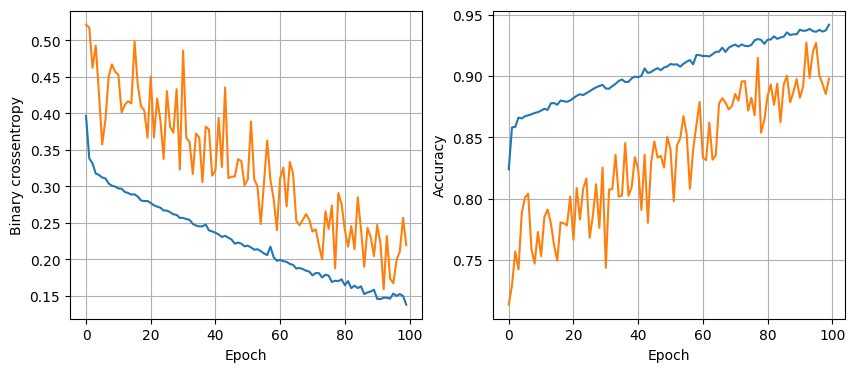

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8497 - loss: 0.5512
64 nodes, dropout 0, lr 0.005, batch size 128


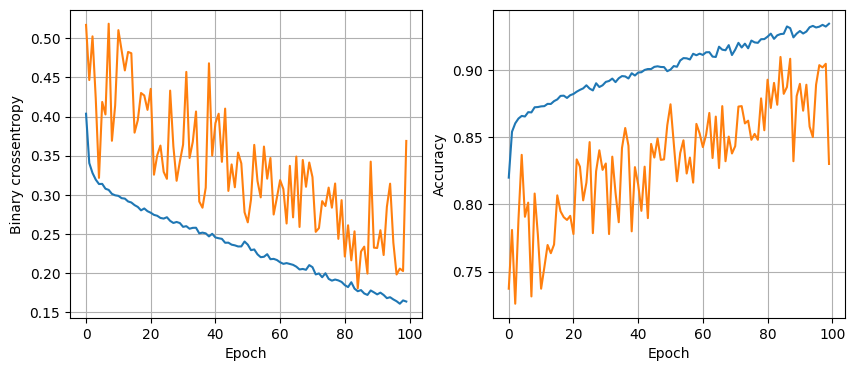

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8609 - loss: 0.4971
64 nodes, dropout 0, lr 0.001, batch size 32


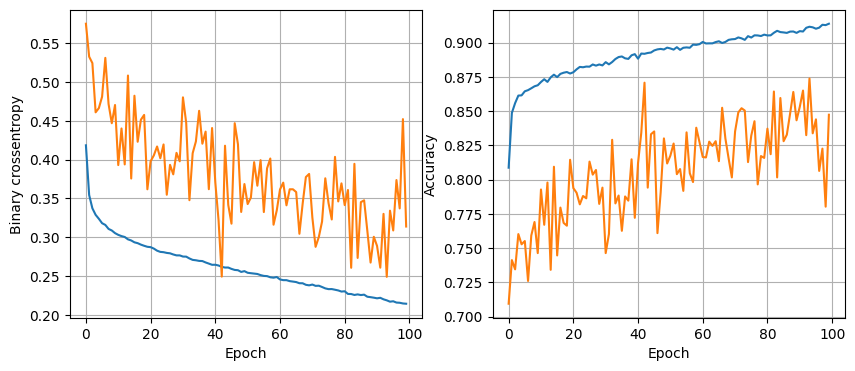

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8517 - loss: 0.3634
64 nodes, dropout 0, lr 0.001, batch size 64


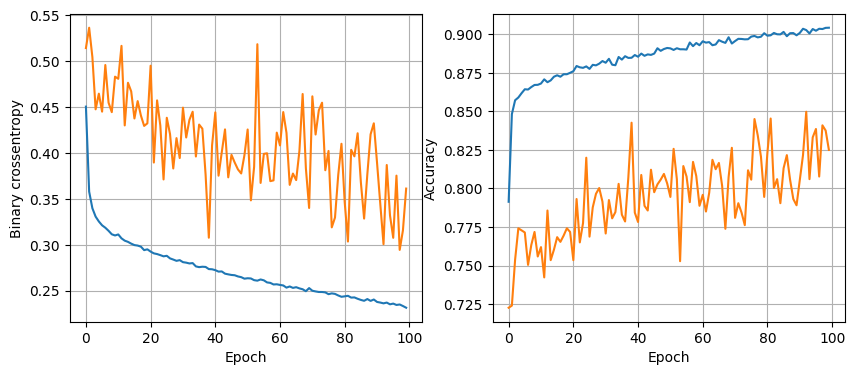

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8606 - loss: 0.3389
64 nodes, dropout 0, lr 0.001, batch size 128


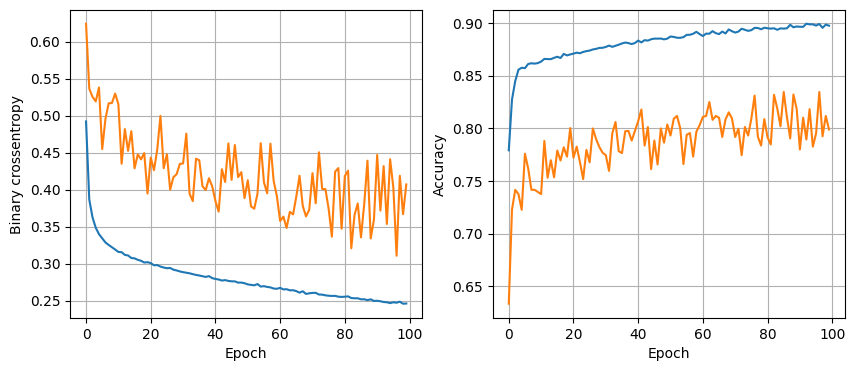

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8678 - loss: 0.3304
64 nodes, dropout 0.2, lr 0.01, batch size 32


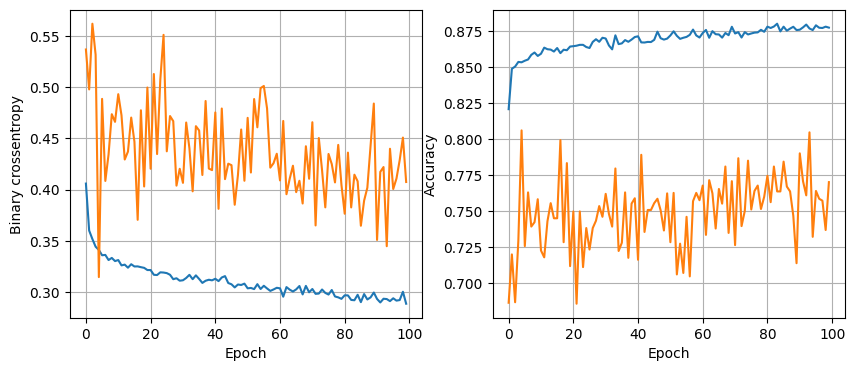

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8781 - loss: 0.3133
64 nodes, dropout 0.2, lr 0.01, batch size 64


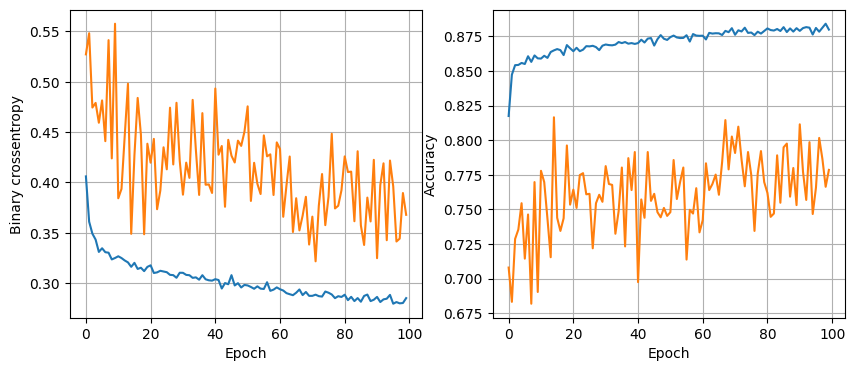

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8784 - loss: 0.3121
64 nodes, dropout 0.2, lr 0.01, batch size 128


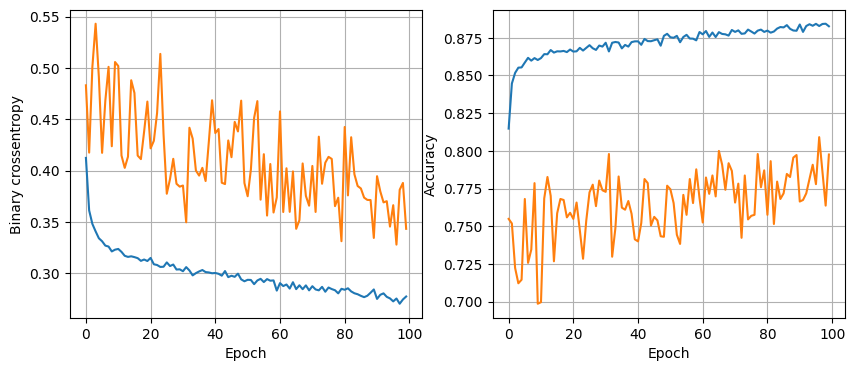

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8698 - loss: 0.3196
64 nodes, dropout 0.2, lr 0.005, batch size 32


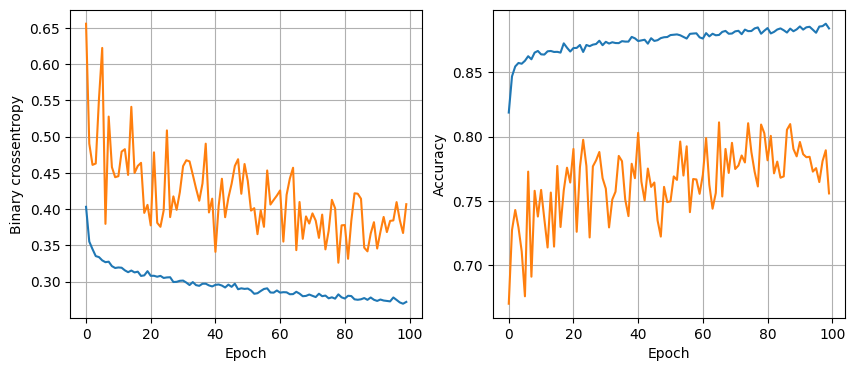

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8738 - loss: 0.3092
64 nodes, dropout 0.2, lr 0.005, batch size 64


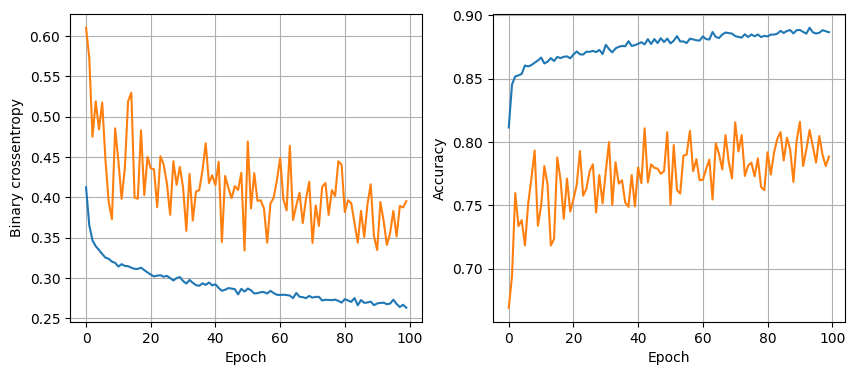

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8770 - loss: 0.3147
64 nodes, dropout 0.2, lr 0.005, batch size 128


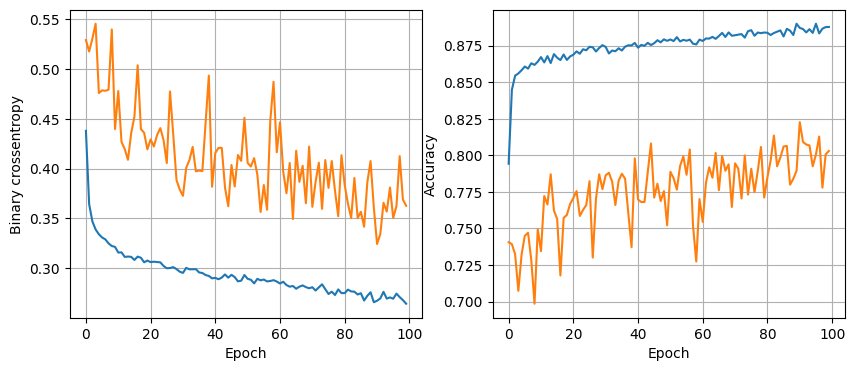

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.3155
64 nodes, dropout 0.2, lr 0.001, batch size 32


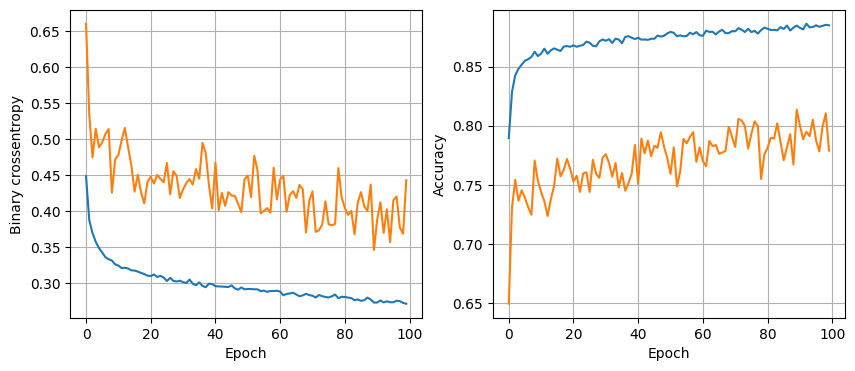

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8735 - loss: 0.3044
64 nodes, dropout 0.2, lr 0.001, batch size 64


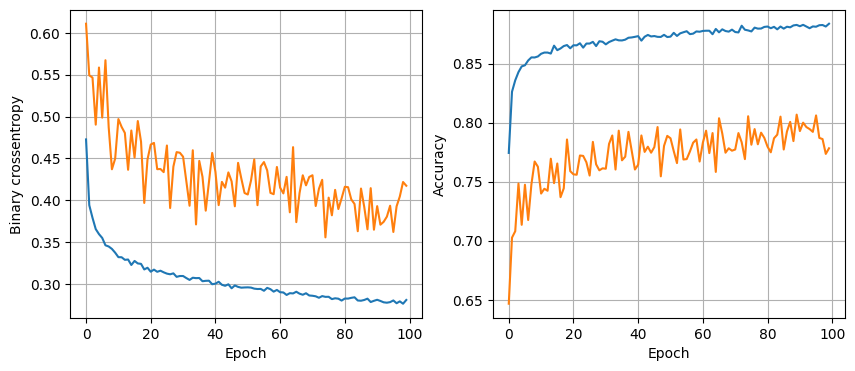

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8818 - loss: 0.2983
64 nodes, dropout 0.2, lr 0.001, batch size 128


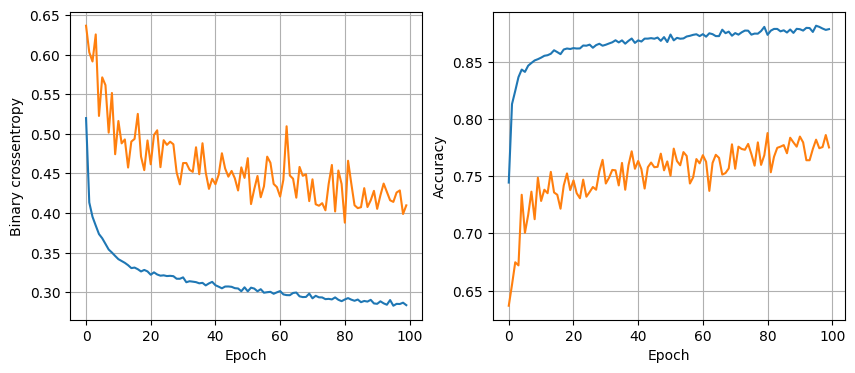

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8707 - loss: 0.2990


In [118]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

In [119]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1330
           1       0.86      0.95      0.91      2474

    accuracy                           0.87      3804
   macro avg       0.88      0.84      0.85      3804
weighted avg       0.87      0.87      0.87      3804



Finalmente, observamos que el modelo más complejo tiene el mejor resultado, pero debemos tomar en cuenta el tiempo que se demora para poder procesar los datos. Con esto debemos tomar la decisión si deseamos utilizar dado el contexto necesario.